# Fusion Neural Network for Emotion Recognition

## Connect to Google Drive

In [2]:
# File manipulation imports for Google Colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/CSCI535")

Mounted at /content/drive


## Packages

In [3]:
!pip install --quiet adabelief-pytorch

In [4]:
# Data Manipulation
import pandas as pd
import numpy as np
from glob import glob
import json
import pickle
# import swifter


# Neural Networks
import torch
import torch.nn as nn
from adabelief_pytorch import AdaBelief

# Metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_curve 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Auxilary
from tqdm import tqdm
from copy import deepcopy
from typing import Tuple
import time
import copy

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import pylab

## Config

In [5]:
AUDIO_TIMESTEPS = 600
VIDEO_TIMESTEPS = 263
BATCH_SIZE = 64
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda:0


## Load Embeddings

In [6]:
# Load audio
audio_data = torch.load('audios_timesteps_wavlm.pt')

In [7]:
# Load text
with open('NEW_EMBEDDINGS_FINALLY.pkl', 'rb') as f_in:
    text_data = pickle.load(f_in)

In [8]:
# Load video
with open('IEMOCAP_embs_dict_with_0.pkl', 'rb') as f_in:
    video_data_raw = pickle.load(f_in)

video_data = {}
for key, value in video_data_raw.items():
    filename = key.split('/')[-1].split('.')[0]
    embedding = value.squeeze(dim=1)
    video_data[filename] = embedding

del video_data_raw

In [9]:
video_keys = set(video_data.keys())
audio_keys = set(audio_data.keys())
text_keys = set(text_data.keys())
shared_keys = video_keys.intersection(audio_keys).intersection(text_keys)

print(f"Video : {len(video_data)}")
print(f"Audio : {len(audio_data)}")
print(f"Text  : {len(text_data)}")
print(f"Shared: {len(shared_keys)}")

Video : 7380
Audio : 7529
Text  : 7380
Shared: 7380


## Load Metadata

In [10]:
# Get filepath for all labeling files
files = set()
for session_num in range(1, 6):
    path = f'IEMOCAP_full_release/Session{session_num}/dialog/EmoEvaluation'
    files.update(glob(path+'/*.txt'))

In [11]:
# Load labels from files
labels = dict()
for file in tqdm(files):
    with open(file, 'r') as f_in:
        for idx, line in enumerate(f_in.readlines()):
            line = line.split('\t')
            if len(line) > 3: 
                labels[line[1]] = line[2]
print(f'\n' + 'Got {len(labels)} labels.')

100%|██████████| 151/151 [01:18<00:00,  1.93it/s]


Got {len(labels)} labels.


In [12]:
# Convert to Data Frame
df = pd.DataFrame(labels, index=['Emotion']).T
df['Filename'] = df.index.to_list()
df['Filepath'] = df['Filename'].apply(lambda filename: 'IEMOCAP_audios/'+filename+'.wav')
df['Emotion'] = df['Emotion'].replace('xxx', 'oth')
df['Emotion'] = df['Emotion'].replace('exc', 'hap')
df_all = df.copy()
df = df[~df['Emotion'].isin(['oth', 'fea', 'sur', 'dis'])]

In [13]:
def get_metadata(row):

    # Handle scripted actions
    if 'script' in row.name:
        parts = row.name.split('_')
        session = parts[0][3:5]
        gender = parts[0][5]
        interaction = parts[1][:-2]
        sequence = parts[1][-2:]
        section = parts[2]
        utterance = parts[3][1:]

    # Handle improvisations
    elif 'impro' in row.name:
        parts = row.name.split('_')
        session = parts[0][3:5]
        gender = parts[0][5]
        interaction = parts[1][:-2]
        sequence = parts[1][-2:]
        section = None
        utterance = parts[2][1:]

    else:
        raise Exception(f'Error on {row.name}')

    return session, gender, interaction, sequence, section, utterance

In [14]:
# Extract Metadata
df[['Session', 'Gender', 'Interaction', 'Sequence', 'Section', 'Utterance']]  = df.apply(lambda row: get_metadata(row), axis='columns', result_type='expand')
df['Session'] = pd.to_numeric(df['Session'])
df['Utterance'] = pd.to_numeric(df['Utterance'])

In [15]:
# Class weights
class_counts = df['Emotion'].value_counts().sort_index()
class_names = class_counts.index.tolist()
class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)

In [16]:
# Generate label encodings
idx_to_label = {idx:label for idx, label in enumerate(class_names)}
label_to_idx = {label:idx for idx, label in enumerate(class_names)}
df['Label'] = df['Emotion'].map(label_to_idx)

In [17]:
# Train, Test, Validation
df_train = df[df['Session'] < 5]
df_valid = df[(df['Session'] == 5) & (df['Utterance'] % 2 == 0)]
df_test = df[(df['Session'] == 5) & (df['Utterance'] % 2 == 1)]

In [18]:
# One Hot Encode labels
OHE = OneHotEncoder(sparse=False)
OHE.fit(np.array(df['Label']).reshape(-1, 1))
true_onehot_train = OHE.transform(np.array(df_train['Label']).reshape(-1, 1))
true_onehot_valid = OHE.transform(np.array(df_valid['Label']).reshape(-1, 1))
true_onehot_test = OHE.transform(np.array(df_test['Label']).reshape(-1, 1))

## Dataloader

In [19]:
class ClassifierDataset(torch.utils.data.Dataset):
    
    def __init__(self, 
                 data_table: pd.core.frame.DataFrame):
        
        self.data_table = data_table.reset_index(drop=True)

        
    def __getitem__(self, idx: int) -> Tuple[torch.tensor, int]:

        self.audio = audio_data[self.data_table.at[idx, 'Filename']]
        self.text = text_data[self.data_table.at[idx, 'Filename']]
        self.video = video_data[self.data_table.at[idx, 'Filename']]

        label = self.data_table.at[idx, 'Emotion']
        self.y = label_to_idx[label]

        return (self.audio, self.text, self.video), self.y
        
    def __len__ (self):
        return len(self.data_table)

In [20]:
# Datasets
train_dataset = ClassifierDataset(df_train)
valid_dataset = ClassifierDataset(df_valid)
test_dataset = ClassifierDataset(df_test)
full_dataset = ClassifierDataset(df)

In [21]:
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size = BATCH_SIZE)
full_loader = torch.utils.data.DataLoader(dataset=full_dataset,
                                           batch_size = BATCH_SIZE)

## Model

In [94]:
class FusionNN(nn.Module):

    def __init__(self, 
                 num_classes: int,
                 audio_size: int = 0, 
                 text_size: int = 0, 
                 video_size: int = 0, 
                 weight: torch.tensor = None, 
                 device: str = 'cpu'):
        
        super(FusionNN, self).__init__()
        self.num_classes = num_classes
        self.weight = weight
        self.device = device
        self.audio_size = audio_size
        self.text_size = text_size
        self.video_size = video_size
        fusion_size = audio_size//4 + text_size//4 + video_size//4

        # Layers
        self.relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        
        # Audio
        if audio_size:
            self.audio_lstm1 = nn.LSTM(audio_size//1, audio_size//2, bidirectional=True, batch_first=True)
            self.audio_ln1 = nn.LayerNorm([AUDIO_TIMESTEPS, audio_size//1])
            self.audio_do1 = nn.Dropout(0.7)

            self.audio_lstm2 = nn.LSTM(audio_size//1, audio_size//4, bidirectional=False, batch_first=True)
            self.audio_ln2 = nn.LayerNorm(audio_size//4)
            self.audio_do2 = nn.Dropout(0.7)

        # Text
        if text_size:
            self.text_fc1 = nn.Linear(text_size, text_size//2)
            self.text_bn1 = nn.BatchNorm1d(text_size//2)
            self.text_do1 = nn.Dropout(0.5)

            self.text_fc2 = nn.Linear(text_size//2, text_size//4)
            self.text_bn2 = nn.BatchNorm1d(text_size//4)
            self.text_do2 = nn.Dropout(0.5)

        # Video
        if video_size:
            self.video_lstm1 = nn.LSTM(video_size//1, video_size//2, bidirectional=True, batch_first=True)
            self.video_ln1 = nn.LayerNorm([VIDEO_TIMESTEPS, video_size//1])
            self.video_do1 = nn.Dropout(0.7)

            self.video_lstm2 = nn.LSTM(video_size//1, video_size//4, bidirectional=False, batch_first=True)
            self.video_ln2 = nn.LayerNorm(video_size//4)
            self.video_do2 = nn.Dropout(0.7)

        # Fusion
        self.fusion_fc1 = nn.Linear(fusion_size, fusion_size)
        self.fusion_bn1 = nn.BatchNorm1d(fusion_size)
        self.fusion_do1 = nn.Dropout(0.5)

        self.fusion_fc2 = nn.Linear(fusion_size, fusion_size)
        self.fusion_bn2 = nn.BatchNorm1d(fusion_size)
        self.fusion_do2 = nn.Dropout(0.5)

        self.fusion_fc3 = nn.Linear(fusion_size, self.num_classes)


        if type(self.weight) == torch.Tensor: self.loss_func = nn.CrossEntropyLoss(weight=weight.to(self.device)).to(self.device)
        else: self.loss_func = nn.CrossEntropyLoss().to(self.device)
        self.optimizer = AdaBelief(self.parameters(), lr=3e-4, eps=1e-12, betas=(0.9,0.999), rectify=False, print_change_log=False)

        # Track loss improvements over epochs
        self.best_loss = float('inf')
        self.best_params = self.parameters

    # x represents our data
    def forward(self, audio_x, text_x, video_x, batch_size):

        # Audio
        if audio_x is not None:
            audio_x, (h_0, c_0) = self.audio_lstm1(audio_x)
            audio_x = self.audio_ln1(audio_x)
            audio_x = self.relu(audio_x) 
            audio_x = self.audio_do1(audio_x)

            audio_x, (h_1, c_1) = self.audio_lstm2(audio_x)
            audio_x = audio_x[:, -1, :] # equivalent of return_sequences = False
            audio_x = self.audio_ln2(audio_x)
            audio_x = self.relu(audio_x) 
            audio_x = self.audio_do2(audio_x)
        else:
            audio_x = torch.zeros((batch_size, self.audio_size//4), dtype=torch.float, device=self.device)

        # Text
        if text_x is not None:
            text_x = self.text_fc1(text_x)
            text_x = self.text_bn1(text_x)
            text_x = self.relu(text_x)
            text_x = self.text_do1(text_x)

            text_x = self.text_fc2(text_x)
            text_x = self.text_bn2(text_x)
            text_x = self.relu(text_x)
            text_x = self.text_do2(text_x)
        else:
            text_x = torch.zeros((batch_size, self.text_size//4), dtype=torch.float, device=self.device)

        # Video
        if video_x is not None:
            video_x, (h_0, c_0) = self.video_lstm1(video_x)
            video_x = self.video_ln1(video_x)
            video_x = self.relu(video_x) 
            video_x = self.video_do1(video_x)

            video_x, (h_1, c_1) = self.video_lstm2(video_x)
            video_x = video_x[:, -1, :] # equivalent of return_sequences = False
            video_x = self.video_ln2(video_x)
            video_x = self.relu(video_x) 
            video_x = self.video_do2(video_x)
        else:
            video_x = torch.zeros((batch_size, self.video_size//4), dtype=torch.float, device=self.device)

        # Fusion
        # print(audio_x.shape)
        # print(text_x.shape)
        # print(video_x.shape)
        x = torch.cat([audio_x, text_x, video_x], dim=-1)
        x = self.fusion_fc1(x)
        x = self.fusion_bn1(x)
        x = self.relu(x)
        x = self.fusion_do1(x)

        x = self.fusion_fc2(x)
        x = self.fusion_bn2(x)
        x = self.relu(x)
        x = self.fusion_do2(x)

        x = self.fusion_fc3(x)
        output = nn.functional.softmax(x, dim=1)
        return output


    # Return a dictionary with the total number of parameters
    def get_num_parameters(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return {'total_parameters': total_params, 'trainable_parameters': trainable_params}

    def fit(self, 
            train_loader: torch.utils.data.dataloader.DataLoader, 
            valid_loader: torch.utils.data.dataloader.DataLoader = None, 
            epochs = 50, 
            print_data = False,
            model_name = None):
        self.model_name = model_name
        
        for epoch in range(epochs):
            start_time = time.time()
            truth_onehot_train = np.ndarray(shape=(0, self.num_classes))
            proba_onehot_train = np.ndarray(shape=(0, self.num_classes))
            LOSS_train, ACC_train, F1_train, ROC_AUC_train = 0.0, 0.0, 0.0, 0.0

            # Training data
            self.train()
            for j, data in enumerate(train_loader):

                # Get the inputs; data is a list of [inputs, labels]
                audio_x, text_x, video_x, y = self.unpack_data(data)    
                audio_len = audio_x.shape[0] if audio_x != None else 0
                text_len = text_x.shape[0] if text_x != None else 0
                video_len = video_x.shape[0] if video_x != None else 0
                batch_size = max(audio_len, text_len, video_len)            

                # Forward (aka predict)
                pred_probas = self.forward(audio_x, text_x, video_x, batch_size)
                pred_labels = torch.argmax(pred_probas, dim=1)

                # Loss
                loss = self.loss_func(pred_probas, y)
                LOSS_train += loss.item()
                
                # Back propagation
                self.optimizer.zero_grad()
                loss.backward() # back progragation
                self.optimizer.step() # gradient descent

                # Store Predictions
                batch_onehot_truth = OHE.transform(y.detach().cpu().numpy().reshape(-1, 1))
                truth_onehot_train = np.concatenate((truth_onehot_train, batch_onehot_truth))
                batch_onehot_proba = pred_probas.detach().cpu().numpy()
                proba_onehot_train = np.concatenate((proba_onehot_train, batch_onehot_proba))

            # Get epoch metrics
            LOSS_train /= len(train_loader)
            ACC_train, F1_train, ROC_AUC_train = self._get_metrics(truth_onehot_train, proba_onehot_train)

            # Evaluate on validation set + Early Stopping
            if valid_loader is not None:
                LOSS_valid, ACC_valid, F1_valid, ROC_AUC_valid = self._evaluate(valid_loader)
                if self._check_early_stop(LOSS_valid): break
            else:
                if self._check_early_stop(LOSS_train): break
            
            # At the end of epoch, print metrics
            if valid_loader is not None:
                print(f'EPOCH: {epoch+1:>3}' + '   |   '  + 
                      f'LOSS: Train = {LOSS_train:.4f}   Valid = {LOSS_valid:.4f}' + '   |   '  + 
                      f'ACCURACY: Train = {ACC_train:.4f}   Valid = {ACC_valid:.4f}' + '   |   '  + 
                      f'F1 SCORE: Train = {F1_train:.4f}   Valid = {F1_valid:.4f}' + '   |   '  + 
                      f'ROC-AUC: Train = {ROC_AUC_train:.4f}   Valid = {ROC_AUC_valid:.4f}' + '   |   '  + 
                      f'DURATION: {(time.time() - start_time):.0f} seconds')
            else:
                print(f'EPOCH: {epoch+1:>3}' + '   |   '  + 
                      f'LOSS: Train = {LOSS_train:.4f}' + '   |   '  + 
                      f'ACCURACY: Train = {ACC_train:.4f}' + '   |   '  + 
                      f'F1 SCORE: Train = {F1_train:.4f}' + '   |   '  + 
                      f'ROC-AUC: Train = {ROC_AUC_train:.4f}' + '   |   '  + 
                      f'DURATION: {(time.time() - start_time):.0f} seconds')

    def _check_early_stop(self, LOSS):
        if LOSS < self.best_loss:
            self.best_loss = LOSS
            self.best_params = self.parameters
            if type(self.model_name) == str: torch.save(self, self.model_name)
            self.patience = 30
            return False
        else:
            self.patience -= 1
            if self.patience <= 0:
                self.parameters = self.best_params
                print('Early Stopping')
                return True

    def _evaluate(self, 
                  valid_loader: torch.utils.data.dataloader.DataLoader):
        # Validation data
        self.eval()
        with torch.no_grad():

            truth_onehot_valid = np.ndarray(shape=(0, self.num_classes))
            proba_onehot_valid = np.ndarray(shape=(0, self.num_classes))
            LOSS_valid, ACC_valid, F1_valid, ROC_AUC_valid = 0.0, 0.0, 0.0, 0.0

            for k, data in enumerate(valid_loader):

                # Get the inputs; data is a list of [inputs, labels]
                audio_x, text_x, video_x, y = self.unpack_data(data)   
                audio_len = audio_x.shape[0] if audio_x != None else 0
                text_len = text_x.shape[0] if text_x != None else 0
                video_len = video_x.shape[0] if video_x != None else 0
                batch_size = max(audio_len, text_len, video_len)              

                # Forward (aka predict)
                pred_probas = self.forward(audio_x, text_x, video_x, batch_size)

                # Loss
                loss = self.loss_func(pred_probas, y)
                LOSS_valid += loss.item()

                # Store Predictions
                batch_onehot_truth = OHE.transform(y.detach().cpu().numpy().reshape(-1, 1))
                truth_onehot_valid = np.concatenate((truth_onehot_valid, batch_onehot_truth))
                batch_onehot_proba = pred_probas.detach().cpu().numpy()
                proba_onehot_valid = np.concatenate((proba_onehot_valid, batch_onehot_proba))

            # Get epoch metrics
            LOSS_valid /= len(valid_loader)
            ACC_valid, F1_valid, ROC_AUC_valid = self._get_metrics(truth_onehot_valid, proba_onehot_valid)

        return LOSS_valid, ACC_valid, F1_valid, ROC_AUC_valid

    def _get_metrics(self, true_onehot, pred_probas):
        true_labels = np.argmax(true_onehot, axis=-1)
        pred_labels = np.argmax(pred_probas, axis=-1)
        acc = accuracy_score(y_true=true_labels, y_pred=pred_labels)
        f1 = f1_score(y_true=true_labels, y_pred=pred_labels, average='macro')
        roc = roc_auc_score(y_true=true_onehot, y_score=pred_probas)
        return acc, f1, roc

    # Predict labels
    def predict(self, 
                test_loader:torch.utils.data.dataloader.DataLoader):
        # Test data
        self.eval()
        with torch.no_grad():
            output = list()

            for _, data in enumerate(test_loader):

                # Get the inputs; data is a list of [inputs, labels]
                audio_x, text_x, video_x, y = self.unpack_data(data)    
                audio_len = audio_x.shape[0] if audio_x != None else 0
                text_len = text_x.shape[0] if text_x != None else 0
                video_len = video_x.shape[0] if video_x != None else 0
                batch_size = max(audio_len, text_len, video_len)          

                # Forward (aka predict)
                pred_probas = self.forward(audio_x, text_x, video_x, batch_size)
                pred_labels = np.argmax(pred_probas.detach().cpu(), axis=-1)

                # Append to output
                pred_labels = pred_labels.tolist()
                output.extend(pred_labels)
            
        return output

    # Predict probabilities
    def predict_probas(self, 
                       test_loader:torch.utils.data.dataloader.DataLoader):
        # Test data
        self.eval()
        with torch.no_grad():
            output = list()

            for _, data in enumerate(test_loader):

                # Get the inputs; data is a list of [inputs, labels]
                audio_x, text_x, video_x, y = self.unpack_data(data)
                audio_len = audio_x.shape[0] if audio_x != None else 0
                text_len = text_x.shape[0] if text_x != None else 0
                video_len = video_x.shape[0] if video_x != None else 0
                batch_size = max(audio_len, text_len, video_len)   

                # Forward (aka predict)
                pred_probas = self.forward(audio_x, text_x, video_x, batch_size)

                # Append to output
                output.extend(pred_probas.tolist())
            
        return output

    # Unpack data and send to device
    def unpack_data(self, data):
        # Get the inputs; data is a list of [inputs, labels]
        X, y = data
        audio_x, text_x, video_x = X
        audio_x = audio_x.to(self.device)
        text_x = text_x.to(self.device)
        video_x = video_x.to(self.device)
        y = y.to(self.device)

        return audio_x, text_x, video_x, y  

## Training

In [95]:
model = FusionNN(audio_size = 400,
                text_size = 768,
                video_size = 512,
                num_classes = len(class_names),
                weight = class_weights,
                device = DEVICE)
model.to(DEVICE)

Weight decoupling enabled in AdaBelief


FusionNN(
  (relu): LeakyReLU(negative_slope=0.01)
  (tanh): Tanh()
  (audio_lstm1): LSTM(400, 200, batch_first=True, bidirectional=True)
  (audio_ln1): LayerNorm((600, 400), eps=1e-05, elementwise_affine=True)
  (audio_do1): Dropout(p=0.7, inplace=False)
  (audio_lstm2): LSTM(400, 100, batch_first=True)
  (audio_ln2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (audio_do2): Dropout(p=0.7, inplace=False)
  (text_fc1): Linear(in_features=768, out_features=384, bias=True)
  (text_bn1): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (text_do1): Dropout(p=0.5, inplace=False)
  (text_fc2): Linear(in_features=384, out_features=192, bias=True)
  (text_bn2): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (text_do2): Dropout(p=0.5, inplace=False)
  (video_lstm1): LSTM(512, 256, batch_first=True, bidirectional=True)
  (video_ln1): LayerNorm((263, 512), eps=1e-05, elementwise_affine=True)
  (video_do1): Dropout(p=

In [96]:
model_name = 'x'
model.fit(train_loader = train_loader,
          valid_loader = valid_loader,
          epochs = 200,
          model_name = model_name+'.pt')

EPOCH:   1   |   LOSS: Train = 1.6160   Valid = 1.6119   |   ACCURACY: Train = 0.1924   Valid = 0.1613   |   F1 SCORE: Train = 0.1808   Valid = 0.1141   |   ROC-AUC: Train = 0.4917   Valid = 0.4758   |   DURATION: 12 seconds
EPOCH:   2   |   LOSS: Train = 1.6129   Valid = 1.6109   |   ACCURACY: Train = 0.1962   Valid = 0.1712   |   F1 SCORE: Train = 0.1857   Valid = 0.1214   |   ROC-AUC: Train = 0.5030   Valid = 0.4469   |   DURATION: 11 seconds
EPOCH:   3   |   LOSS: Train = 1.6026   Valid = 1.6064   |   ACCURACY: Train = 0.2166   Valid = 0.2475   |   F1 SCORE: Train = 0.1978   Valid = 0.1203   |   ROC-AUC: Train = 0.5329   Valid = 0.5011   |   DURATION: 11 seconds
EPOCH:   4   |   LOSS: Train = 1.6050   Valid = 1.6063   |   ACCURACY: Train = 0.2266   Valid = 0.2463   |   F1 SCORE: Train = 0.2063   Valid = 0.1771   |   ROC-AUC: Train = 0.5292   Valid = 0.5038   |   DURATION: 11 seconds
EPOCH:   5   |   LOSS: Train = 1.5949   Valid = 1.6058   |   ACCURACY: Train = 0.2341   Valid = 0.20

## Evaluate Model

In [97]:
model = torch.load(f=model_name+'.pt')
pd.options.display.float_format = "{:,.2f}".format

In [98]:
# Evaluate on test data
truth_test = df_test['Emotion'].map(label_to_idx)

# Accuracy
preds_test = model.predict(test_loader)
probas_test = np.array(model.predict_probas(test_loader))
labels_test = pd.DataFrame(probas_test, columns=class_names)

# {'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'}
onehot_encoder = OneHotEncoder(sparse=False)
true_onehot = onehot_encoder.fit_transform(np.array(truth_test).reshape(-1, 1))
pred_onehot = onehot_encoder.transform(np.array(preds_test).reshape(-1, 1))

# Metrics
ACC_test = accuracy_score(true_onehot, pred_onehot)
print(f'Test Accuracy: {ACC_test:.5f}')
F1_test = f1_score(true_onehot, pred_onehot, average='macro')
print(f'Test F1 Macro: {F1_test:.5f}')
ROC_test = roc_auc_score(true_onehot, pred_onehot)
print(f'ROC AUC: {ROC_test:.5f}')

# Save performance to csv
performance = {'accuracy': ACC_test,
               'f1_macro': F1_test,
               'roc_auc': ROC_test}

df_performance = pd.DataFrame(performance, index=[0])
df_performance.to_csv(f'performance/{model_name}.csv', index=False)

Test Accuracy: 0.21852
Test F1 Macro: 0.19640
ROC AUC: 0.51702


In [99]:
# Store predictions for all samples
truth_full = df['Emotion'].map(label_to_idx)
probas_full = np.array(model.predict_probas(full_loader))
labels_full = pd.DataFrame(probas_full, columns=class_names)
output = pd.concat([df[['Filename']].reset_index(drop=True), labels_full], axis='columns')
output.to_csv(f'predictions/{model_name}.csv', index=False)

In [100]:
output.sample(3)

,Filename,ang,fru,hap,neu,sad
965,Ses05F_impro02_M005,0.04,0.15,0.09,0.49,0.23
288,Ses05M_script02_1_M031,0.09,0.23,0.17,0.30,0.21
404,Ses01F_script02_1_M010,0.02,0.07,0.02,0.86,0.03


In [101]:
# Predictions
pred_label_counts = pd.Series(preds_test).value_counts().sort_index()
pred_label_counts.index = pred_label_counts.index.map(idx_to_label)
pred_label_counts = pred_label_counts/sum(pred_label_counts * 10e-3)
pred_label_counts.name = 'Predicted'

# Truth
truth_label_counts = pd.Series(truth_test).value_counts().sort_index()
truth_label_counts.index = truth_label_counts.index.map(idx_to_label)
truth_label_counts = truth_label_counts/sum(truth_label_counts * 10e-3)
truth_label_counts.name = 'Truth'

# Merge and calculate error
test_errors = pd.concat([pred_label_counts, truth_label_counts], axis='columns')
test_errors['Total Error'] = test_errors['Predicted'] - test_errors['Truth']
test_errors['Percentage Error'] = 100*(test_errors['Predicted'] - test_errors['Truth']) / test_errors['Truth']
test_errors

,Predicted,Truth,Total Error,Percentage Error
ang,13.83,10.86,2.96,27.27
fru,25.43,22.72,2.72,11.96
hap,1.73,28.64,-26.91,-93.97
neu,33.95,22.59,11.36,50.27
sad,25.06,15.19,9.88,65.04


### Confusion Matrix

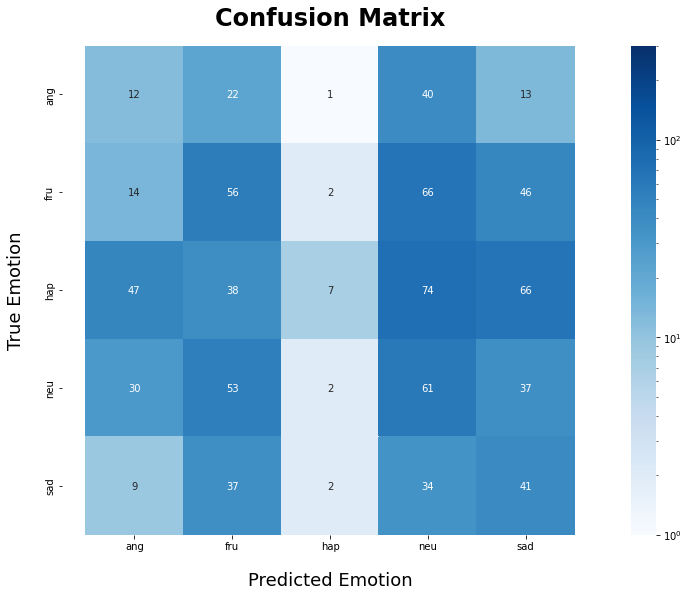

In [102]:
conf_mat = confusion_matrix(truth_test, preds_test)#, labels=class_names)
df_cm = pd.DataFrame(conf_mat, index = class_names,
                     columns = class_names)
plt.figure(figsize = (12,9))
plt.title('Confusion Matrix', fontsize = 24, pad = 20, fontweight='bold')
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', norm=LogNorm(vmax=300))
plt.ylabel('True Emotion', fontsize = 18, labelpad = 20)
plt.xlabel('Predicted Emotion', fontsize = 18, labelpad = 20)
plt.axis('equal')
plt.savefig(f'figures/CM_{model_name}.png')
plt.show()

### ROC

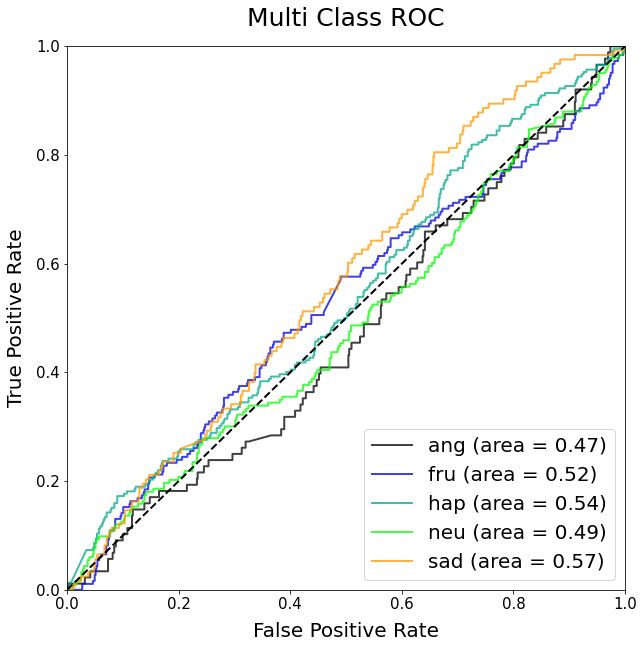

In [103]:
# Data for the plots
N_CLASSES = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(true_onehot[:, i], probas_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC-AUC Plot: Class Scores
fig, ax = plt.subplots(figsize=(10,10))
colors = []
cm = pylab.get_cmap('nipy_spectral')
for i in range(N_CLASSES):
    color = cm(1.*i/N_CLASSES)
    colors.append(color)

for i, color in zip(range(N_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, alpha=0.75,
             label='{0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('False Positive Rate', fontsize=20, labelpad=10)
plt.ylabel('True Positive Rate', fontsize=20, labelpad=10)
plt.title('Multi Class ROC', fontsize=25, pad=20)
plt.legend(fontsize=20, loc="lower right")
plt.savefig(f'figures/ROC_{model_name}.png')
plt.show()

## End